In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2025-07-13 11:25:58.958900: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-13 11:25:58.985397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-13 11:25:58.985419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-13 11:25:58.986138: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-13 11:25:58.990450: I tensorflow/core/platform/cpu_feature_guar

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(f"gpus: {gpus}")

tf.test.is_built_with_cuda()

gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-07-13 11:26:00.050189: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-13 11:26:00.057287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-13 11:26:00.060216: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

# ... (all imports remain the same) ...
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics


# --- Data Loading and Environment Class (Unchanged) ---
# The load_and_prepare_data and CryptoTradingEnvironment classes are identical to the previous version.
# ... (paste them here) ...
def load_and_prepare_data(filepath, symbols):
    # ... (same as before) ...
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found at {filepath}. Please ensure the file exists.")
    print(f"Loading data from {filepath}...")
    df = pd.read_csv(filepath, compression='gzip', parse_dates=['timestamp']).set_index('timestamp')
    all_data = {}
    print("Processing symbols:", symbols)
    for symbol in symbols:
        symbol_df = df[df['symbol'] == symbol][['close', 'volume']]
        symbol_df['close_return'] = symbol_df['close'].pct_change()
        symbol_df['volume_return'] = symbol_df['volume'].pct_change()
        all_data[symbol] = symbol_df[['close_return', 'volume_return', 'close']]
    combined_df = pd.concat(all_data, axis=1)
    combined_df.columns = ['_'.join(col).strip() for col in combined_df.columns.values]
    combined_df.ffill(inplace=True)
    combined_df.dropna(inplace=True)
    print(f"Data prepared. Shape: {combined_df.shape}")
    return combined_df

class CryptoTradingEnvironment(py_environment.PyEnvironment):
    # ... (__init__, action_spec, observation_spec, _get_minimal_observation are unchanged) ...
    def __init__(self, data, symbols, context_len=10):
        super().__init__()
        self._data = data
        self._context_len = context_len
        self._symbols = symbols
        self._num_cryptos = len(self._symbols)
        self._minimal_obs_size = self._num_cryptos * 2 
        observation_size = self._minimal_obs_size * self._context_len
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=self._num_cryptos * 2 - 1, name='action'
        )
        self._observation_spec = array_spec.ArraySpec(
            shape=(observation_size,), dtype=np.float32, name='context'
        )
        data_spec = tensor_spec.TensorSpec([self._minimal_obs_size], dtype=tf.float32, name='minimal_observation')
        self._replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
            data_spec=data_spec, batch_size=1, max_length=self._context_len + 5
        )
        self._current_step_index = 0
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _get_minimal_observation(self, index):
        obs_slice = []
        for symbol in self._symbols:
            obs_slice.append(self._data.iloc[index][f'{symbol}_close_return'])
            obs_slice.append(self._data.iloc[index][f'{symbol}_volume_return'])
        return np.array(obs_slice, dtype=np.float32)

    def _observe(self):
        num_items_in_buffer = self._replay_buffer.num_frames()
        if num_items_in_buffer == 0:
            return np.zeros(self._observation_spec.shape, dtype=np.float32)

        dataset = self._replay_buffer.as_dataset(single_deterministic_pass=True)
        batched_items = next(iter(dataset.batch(num_items_in_buffer)))
        
        # Select only the data tensor (at index 0) from the (data, info) tuple
        all_items_tensor = batched_items[0]
        
        # --- FIX IS HERE ---
        # The squeeze operation is no longer necessary and was causing the error.
        # all_items_tensor already has the desired shape of [num_items, feature_size].
        # We can use it directly.
        
        # The rest of the logic uses all_items_tensor, which we will now call all_items.
        all_items = all_items_tensor
        context = tf.reshape(all_items[-self._context_len:], [-1])
        return context.numpy()

    # ... (_reset and _step methods are unchanged) ...
    def _reset(self):
        self._replay_buffer.clear()
        self._episode_ended = False
        self._current_step_index = self._context_len 
        for i in range(self._current_step_index):
            self._replay_buffer.add_batch(tf.expand_dims(self._get_minimal_observation(i), 0))
        return ts.restart(self._observe())

    def _step(self, action):
        if self._episode_ended:
            return self.reset()
        crypto_index = action // 2
        is_buy_action = action % 2 == 0
        column_name = f'{self._symbols[crypto_index]}_close'
        current_price = self._data.iloc[self._current_step_index][column_name]
        next_price = self._data.iloc[self._current_step_index + 1][column_name]
        reward = ((next_price - current_price) / current_price) if is_buy_action else ((current_price - next_price) / current_price)
        self._replay_buffer.add_batch(tf.expand_dims(self._get_minimal_observation(self._current_step_index), 0))
        self._current_step_index += 1
        if self._current_step_index >= len(self._data) - 2:
            self._episode_ended = True
        observation = self._observe()
        return ts.termination(observation, reward) if self._episode_ended else ts.transition(observation, reward)

# --- Configuration & Main Script (MODIFIED) ---
CRYPTO_NAMES = ['BTC/USDT', 'DOGE/USDT', 'XRP/USDT', 'ETH/USDT', 'SOL/USDT']
DATA_FILEPATH = 'data/ohlcv.csv.gz'
CONTEXT_LENGTH = 10
NUM_TRAINING_STEPS = 100

data = load_and_prepare_data(DATA_FILEPATH, CRYPTO_NAMES)

if NUM_TRAINING_STEPS > len(data) - CONTEXT_LENGTH - 5:
    NUM_TRAINING_STEPS = len(data) - CONTEXT_LENGTH - 5
    print(f"\nWarning: Training steps reduced to {NUM_TRAINING_STEPS} to fit available data.")

tf_env = tf_py_environment.TFPyEnvironment(CryptoTradingEnvironment(data, symbols=CRYPTO_NAMES, context_len=CONTEXT_LENGTH))

agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    alpha=1.0,
    dtype=tf.float32
)

def train_step(trajectory):
    if not trajectory.is_last():
        time_axised_trajectory = tf.nest.map_structure(lambda t: tf.expand_dims(t, 1), trajectory)
        agent.train(time_axised_trajectory)

# --- NEW: "Perfect Foresight Oracle" for RegretMetric ---
# This function 'cheats' by looking at the future to calculate the best possible reward.
# It can only be used for evaluation, NOT for agent decision-making.
def optimal_reward_oracle(observation):
    """
    Calculates the best possible reward for the current step by looking ahead.
    NOTE: The 'observation' is unused, but required by the metric's API.
    We rely on the environment's internal state.
    """
    # Get the python environment to access its internal state
    py_env = tf_env.pyenv.envs[0]
    current_step = py_env._current_step_index
    
    if current_step >= len(py_env._data) - 2:
        return 0.0 # No future data available

    all_possible_rewards = []
    num_actions = py_env.action_spec().maximum + 1
    
    for action in range(num_actions):
        crypto_index = action // 2
        is_buy_action = action % 2 == 0
        symbol = py_env._symbols[crypto_index]
        column_name = f'{symbol}_close'
        
        current_price = py_env._data.iloc[current_step][column_name]
        next_price = py_env._data.iloc[current_step + 1][column_name]
        
        reward = ((next_price - current_price) / current_price) if is_buy_action else ((current_price - next_price) / current_price)
        all_possible_rewards.append(reward)
        
    return np.max(all_possible_rewards).astype(np.float32)

# Use our oracle with the RegretMetric
regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_oracle)

def get_action_name(action):
    crypto_index = action // 2
    action_type = "BUY" if action % 2 == 0 else "SELL"
    return f"{action_type} {CRYPTO_NAMES[crypto_index]}"
    
driver = dynamic_step_driver.DynamicStepDriver(
    env=tf_env,
    policy=agent.policy,
    num_steps=NUM_TRAINING_STEPS,
    observers=[train_step, regret_metric]
)

print(f"\nStarting training for {NUM_TRAINING_STEPS} steps...")
driver.run()
print("Training finished.")

cumulative_regret = regret_metric.result().numpy()
print(f"cumulative_regret: {cumulative_regret}")
print(f"\nCumulative Regret vs. Perfect Foresight Oracle: {cumulative_regret:.4f}")
print("This measures the total profit the agent missed compared to a perfect model.")

print("\n--- Evaluation Loop ---")
time_step = tf_env.reset()
cumulative_reward = 0
num_eval_steps = 100
rewards = []
for i in range(num_eval_steps):
    if time_step.is_last():
        print("Evaluation data ended. Resetting.")
        time_step = tf_env.reset()
        
    action_step = agent.policy.action(time_step)
    action = action_step.action.numpy()[0]
    time_step = tf_env.step(action)
    reward = time_step.reward.numpy()[0]
    cumulative_reward += reward
    rewards.append(reward)
    #print(f"Step {i+1}: Chose action '{get_action_name(action)}', received reward {reward:.6f}")

print(f"\nFinal cumulative reward over last {num_eval_steps} steps: {cumulative_reward:.6f}")

Loading data from data/ohlcv.csv.gz...
Processing symbols: ['BTC/USDT', 'DOGE/USDT', 'XRP/USDT', 'ETH/USDT', 'SOL/USDT']
Data prepared. Shape: (13093, 15)


2025-07-13 11:26:00.470902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-13 11:26:00.475085: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-13 11:26:00.478131: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-


Starting training for 100 steps...
Training finished.
cumulative_regret: -0.0007016747258603573

Cumulative Regret vs. Perfect Foresight Oracle: -0.0007
This measures the total profit the agent missed compared to a perfect model.

--- Evaluation Loop ---

Final cumulative reward over last 100 steps: -0.107816


Text(0.5, 0, 'Number of Iterations')

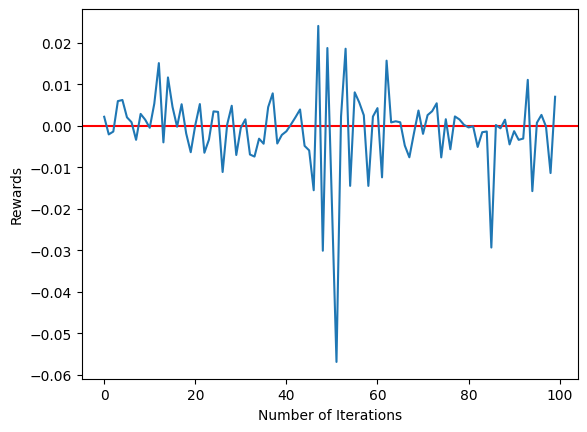

In [7]:
plt.axhline(y=0.0, color='r', linestyle='-')
plt.plot(rewards)
plt.ylabel('Rewards')
plt.xlabel('Number of Iterations')